In [1]:
import sys
sys.path.insert(0, 'Utilities/')
import S3Data
import Modes
import plottingPrimary
import seaborn as sns

In [8]:
import pandas as pd
import numpy as np

In [9]:
Battery = S3Data.ParquetToDataFrame(option="battery", date='26-09-2022', vehicle_no='MBX0007ZB1D175593')
df = Battery.get_data()
df.head()

,eventAt,vehicleNo,requestUuid,dte,odometer,soc,battery_voltage,5v_supply_fault,headlight,engine_speed,...,severe_ksi_overvoltage_fault,vcl_time_error,motorphase_open_fault,encoder_fault,drive_mode,brake_pedal,delta_t,timestamp,Date_conv,Time_conv
1231,1664133874286,MBX0007ZB1D175593,0d68011d-df00-4126-ae46-109991a9e812,NaN,NaN,83.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-25 19:23:45.267,2022-09-25,19:23:45.267000
1232,1664133874287,MBX0007ZB1D175593,f373ff45-e665-495d-938b-053f93c7ca88,NaN,NaN,83.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2022-09-25 19:23:46.267,2022-09-25,19:23:46.267000
1233,1664133874287,MBX0007ZB1D175593,e6698350-d749-4dc5-b074-1f78a1714d75,NaN,NaN,83.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2022-09-25 19:23:47.267,2022-09-25,19:23:47.267000
1234,1664133874287,MBX0007ZB1D175593,866d21b4-ebc8-4e3c-a85f-fe9a60905d0b,NaN,NaN,83.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2022-09-25 19:23:48.267,2022-09-25,19:23:48.267000
1235,1664133874287,MBX0007ZB1D175593,fff6cbd1-b3ea-439a-8f95-d0c0b58cfb0c,NaN,NaN,83.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2022-09-25 19:23:49.267,2022-09-25,19:23:49.267000


In [10]:
df = Modes.operation_modes(df)
df.head()

,vehicleNo,Date_conv,Time_conv,eventAt,soc,battery_voltage,time,odometer,vehicle_speed,current,delta_t,acceleration,mode,dummy,Frequency_per_event
1231,MBX0007ZB1D175593,2022-09-25,19:23:45.267000,1664133874286,83.0,NaN,1664133825267,NaN,NaN,44.1,NaN,NaN,Charging,1,1
1232,MBX0007ZB1D175593,2022-09-25,19:23:46.267000,1664133874287,83.0,NaN,1664133826267,NaN,NaN,44.0,1.0,NaN,Charging,1,2
1233,MBX0007ZB1D175593,2022-09-25,19:23:47.267000,1664133874287,83.0,NaN,1664133827267,NaN,NaN,44.0,1.0,NaN,Charging,1,3
1234,MBX0007ZB1D175593,2022-09-25,19:23:48.267000,1664133874287,83.0,NaN,1664133828267,NaN,NaN,44.0,1.0,NaN,Charging,1,4
1235,MBX0007ZB1D175593,2022-09-25,19:23:49.267000,1664133874287,83.0,NaN,1664133829267,NaN,NaN,44.0,1.0,NaN,Charging,1,5


<AxesSubplot:xlabel='mode', ylabel='count'>

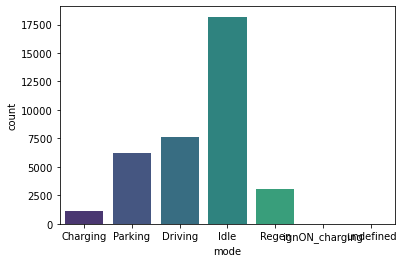

In [11]:
df['mode'].value_counts()

sns.countplot(x='mode',data=df, palette='viridis')

In [12]:
df.drop(['vehicleNo','delta_t','acceleration','Date_conv', 'Time_conv', 'eventAt' ], axis=1, inplace = True)

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
m = df['mode'].ne(df['mode'].shift()).cumsum()
g1 = df.groupby(m).cumcount().add(1).astype(str)
g2 = (df.loc[~m.duplicated(), 'mode']
        .groupby(df['mode']).cumcount().add(1)
        .reindex(df.index, method='ffill')
        .astype(str))
s1=pd.Series(g2).astype(int)
s2=pd.Series(g1).astype(int)
df['Event_no'] = s1.to_frame()
df['Frequency_per_event'] = s2.to_frame()

df_1=df[df.groupby(['mode','Event_no'])['Frequency_per_event'].transform(min) == df['Frequency_per_event']]
df_2=df[df.groupby(['mode','Event_no'])['Frequency_per_event'].transform(max) == df['Frequency_per_event']]
df_3=pd.merge(df_1, df_2, on=['mode','Event_no'])


df_3.rename(
     columns=({ 'soc_x':'soc_start', 'battery_voltage_x':'battery_voltage_start', 'time_x':'time_start',
               'odometer_x':'odometer_start', 'vehicle_speed_x':'vehicle_speed_start','current_x':'current_start',
               'Frequency_per_event_x':'Frequency_per_event_start','soc_y':'soc_end', 'battery_voltage_y':'battery_voltage_end',
               'time_y':'time_end','odometer_y':'odometer_end','vehicle_speed_y':'vehicle_speed_end','current_y':'current_end',
               'Frequency_per_event_y':'Frequency_per_event_end'}), 
inplace=True,
)

df_3 = df_3[['mode', 'Event_no', 'soc_start', 'battery_voltage_start',
       'time_start', 'odometer_start', 'vehicle_speed_start', 'current_start',
       'Frequency_per_event_start', 'soc_end', 'battery_voltage_end',
       'time_end', 'odometer_end', 'vehicle_speed_end', 'current_end',
       'Frequency_per_event_end']]

In [ ]:
df_new = df.copy()
x=df_new.groupby(by='mode')
df_new = pd.DataFrame(df_new)
df_new.head()

In [ ]:
df_new['idx'] = (df.groupby('mode').cumcount() + 1)
df_new.set_index("idx", drop=True)
df_new.head()
# df_new["new_idx"] = df[["idx","mode"]].astype(str).apply(lambda x: "".join(x),axis=1)
# df_new.head(30)

In [ ]:
df['idx'] = df.groupby(['mode', 'Frequency_per_event']).ngroup()

In [ ]:
df3 = df.set_index(['mode', 'Frequency_per_event'])


In [ ]:
import pandas as pd
x=df3.groupby(by='mode')
new_df = pd.DataFrame(x)

In [ ]:
new_df.to_csv('new_df.csv')

In [ ]:
x.head()

In [ ]:
df3.head()
df3.to_csv('df3.csv')

In [ ]:
df3.head()

In [ ]:
df3.loc['time', 'rebounds']

In [ ]:
m = df_new['mode'].ne(df_new['mode'].shift()).cumsum()
g1 = df_new.groupby(m).cumcount().add(1).astype(str)
g2 = (df_new.loc[~m.duplicated(), 'mode']
        .groupby(df_new['mode']).cumcount().add(1).astype(str))
s1=pd.Series(g2).astype(int)
s2=pd.Series(g1).astype(int)
df['Event_no'] = s1.to_frame()
df['Frequency_per_event'] = s2.to_frame()

df_1=df[df.groupby(['mode','Event_no'])['Frequency_per_event'].transform(min) == df['Frequency_per_event']]
df_2=df[df.groupby(['mode','Event_no'])['Frequency_per_event'].transform(max) == df['Frequency_per_event']]
df_3=pd.merge(df_1, df_2, on=['mode','Event_no'])


df_3.rename(
     columns=({ 'soc_x':'soc_start', 'battery_voltage_x':'battery_voltage_start', 'time_x':'time_start',
               'odometer_x':'odometer_start', 'vehicle_speed_x':'vehicle_speed_start','current_x':'current_start',
               'Frequency_per_event_x':'Frequency_per_event_start','soc_y':'soc_end', 'battery_voltage_y':'battery_voltage_end',
               'time_y':'time_end','odometer_y':'odometer_end','vehicle_speed_y':'vehicle_speed_end','current_y':'current_end',
               'Frequency_per_event_y':'Frequency_per_event_end'}), 
inplace=True,
)

df_3 = df_3[['mode', 'Event_no', 'soc_start', 'battery_voltage_start',
       'time_start', 'odometer_start', 'vehicle_speed_start', 'current_start',
       'Frequency_per_event_start', 'soc_end', 'battery_voltage_end',
       'time_end', 'odometer_end', 'vehicle_speed_end', 'current_end',
       'Frequency_per_event_end']]



In [ ]:
# Secondary params
df_driving=df_3[df_3['mode']=='Driving']
df_Parking=df_3[df_3['mode']=='Parking']
df_Idle=df_3[df_3['mode']=='Idle']
df_Regen=df_3[df_3['mode']=='Regen']
df_Charging=df_3[df_3['mode']=='Charging']

In [ ]:
## 1. Driving

#Driving Start Time

df_driving['time_start'][df_driving['Event_no']==df_driving['Event_no'].min()]

#Driving End Time

df_driving['time_end'][df_driving['Event_no']==df_driving['Event_no'].max()]

#Driving Start SOC 

df_driving['soc_start'][df_driving['Event_no']==df_driving['Event_no'].min()]

#Driving End SOC

df_driving['soc_end'][df_driving['Event_no']==df_driving['Event_no'].max()]

#Driving Start Voltage

df_driving['battery_voltage_start'][df_driving['Event_no']==df_driving['Event_no'].min()]

#Driving End Voltage

df_driving['battery_voltage_end'][df_driving['Event_no']==df_driving['Event_no'].max()]

#Driving Current (Average)

abs(df_driving['current_start']).mean()

#Driving Current (Maximum)

abs(df_driving['current_start']).max()

#Driving Current (Minimum)

abs(df_driving['current_start']).min()

#Driving Current Histogram

bins = [0, 25, 50, 75, 100, 125, 150]
ax=plt.hist(abs(df_driving['current_start']).values, bins=bins, edgecolor="k")
plt.show()

